12:35:58 - cmdstanpy - INFO - compiling stan file /workspace/project/data_analytics/model1_ppc.stan to exe file /workspace/project/data_analytics/model1_ppc


(1000, 19)
(1000,)


12:36:13 - cmdstanpy - INFO - compiled model executable: /workspace/project/data_analytics/model1_ppc
12:36:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

12:36:13 - cmdstanpy - INFO - CmdStan done processing.


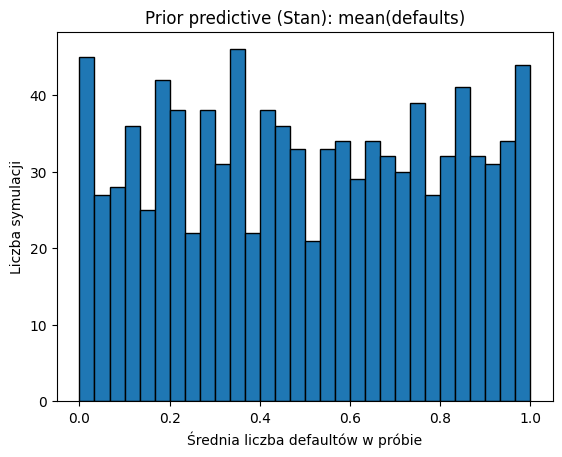

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel

# === Wczytanie danych z CSV ===
X = pd.read_csv("./project/data_analytics/X.csv").values.astype(np.float32)
y = pd.read_csv("./project/data_analytics/y.csv")["default"].values.astype(np.int32)
print(X.shape)
print(y.shape)
N, K = X.shape

stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === PRIOR PREDICTIVE CHECK – DANE (STAN) ===
ppc_model = CmdStanModel(stan_file="./project/data_analytics/model1_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df[[col for col in ppc_df.columns if "y_sim" in col]].values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)

plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.ylabel("Liczba symulacji")
plt.show()

/tmp/ipykernel_106/3474804932.py:4: RuntimeWarning: invalid value encountered in cast
  X = X.drop(columns=['default']).values.astype(np.int32)
12:36:14 - cmdstanpy - INFO - CmdStan start processing


[[1, 0, 1, 1, 4], [2, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [-1, 0, 1, 1, 0], [-1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 2, 2, 1], [0, 0, -1, -1, 0], [0, 0, -1, -1, 0], [0, 0, -1, -1, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, -1, -1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 17], [-1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [-1, 0, 1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [-1, 0, 0, 0, 1], [0, 0, -1, -1, 0], [-1, 0, 0, 0, 0], [-1, 0, 0, 0, 0], [0, 0, 2, 1, 2], [0, 0, 0, 0, 0], [0, 0, 0, 0, -1], [0, 0, 0, 0, 1], [0, 0, 1, 1, 0], [0, 0, 0, 0, 0], [1, 0, 1, 2, 0], [0, 0, 0, 0, 3], [0, 0, 2, 1, 0], [0, 0, -1, -1, 0], [0, 0, 0, 0, 0], [0, 0, -1, -1, 0], [-1, 0, 1, 1, 1], [0, 0, -1, -1, 0], [0, 0, -1, -1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [1, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 2, 1, 4], [0, 0, 2, 2, 2], [0, 0, 1, 0, 0], [0, 0, -1, -1, 0], [-1, 0, 1, 1, 0], [-1, 0, 0, 0, 0], [-1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [-1, 0, 0, 0, 

chain 1 |          | 00:00 Status

12:36:15 - cmdstanpy - INFO - CmdStan done processing.



     chain__  iter__  draw__  lp__  accept_stat__      alpha   beta[1]  \
0        1.0     1.0     1.0   0.0            0.0   2.946130 -0.354216   
1        1.0     2.0     2.0   0.0            0.0  -3.510910  0.602983   
2        1.0     3.0     3.0   0.0            0.0  -9.041010  0.133559   
3        1.0     4.0     4.0   0.0            0.0   5.408300  0.770051   
4        1.0     5.0     5.0   0.0            0.0  -6.231520  2.680120   
..       ...     ...     ...   ...            ...        ...       ...   
995      1.0   996.0   996.0   0.0            0.0  -4.443110  0.738130   
996      1.0   997.0   997.0   0.0            0.0  11.362000  2.662400   
997      1.0   998.0   998.0   0.0            0.0  11.255500 -0.506032   
998      1.0   999.0   999.0   0.0            0.0  -3.874450 -1.711220   
999      1.0  1000.0  1000.0   0.0            0.0  -0.029161 -3.851930   

      beta[2]   beta[3]   beta[4]  ...  y_sim[4991]  y_sim[4992]  y_sim[4993]  \
0    1.152020  0.279257 -0.51

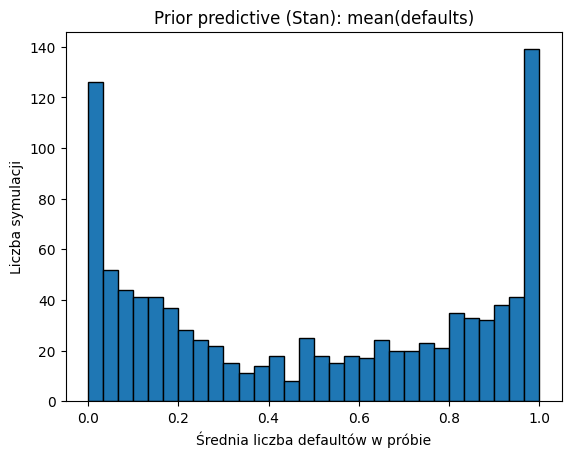

In [70]:
X = pd.read_csv("./project/data_analytics/processed_data_standarized_only.csv")
y = X["default"].values.astype(np.int32)

X = X.drop(columns=['default']).values.astype(np.int32)
N, K = X.shape

print(X.tolist())
print(y)
stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === PRIOR PREDICTIVE CHECK – DANE (STAN) ===
ppc_model = CmdStanModel(stan_file="./project/data_analytics/model1_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df[[col for col in ppc_df.columns if "y_sim" in col]].values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)
print(ppc_df)
plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.ylabel("Liczba symulacji")
plt.show()

12:36:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:36:24 - cmdstanpy - INFO - CmdStan done processing.


12:36:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1000 divergent transitions (100.0%)
	Chain 2 had 998 divergent transitions (99.8%)
	Chain 3 had 1000 divergent transitions (100.0%)
	Chain 4 had 998 divergent transitions (99.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


         r_hat  ess_bulk  ess_tail
alpha     1.27      11.0      19.0
beta[0]   1.64       6.0      14.0
beta[1]   1.72       6.0      41.0
beta[2]   2.80       5.0      12.0
beta[3]   2.93       5.0      12.0
beta[4]   1.71       6.0      13.0
Divergences: 3996


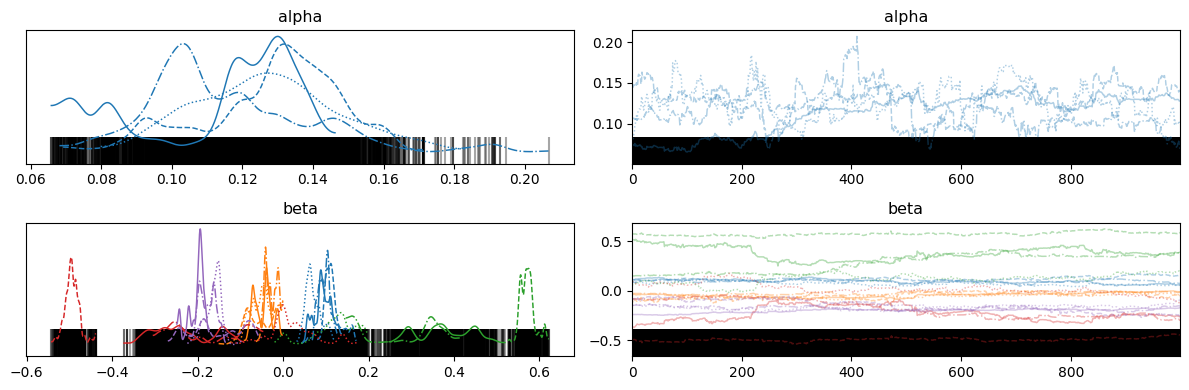

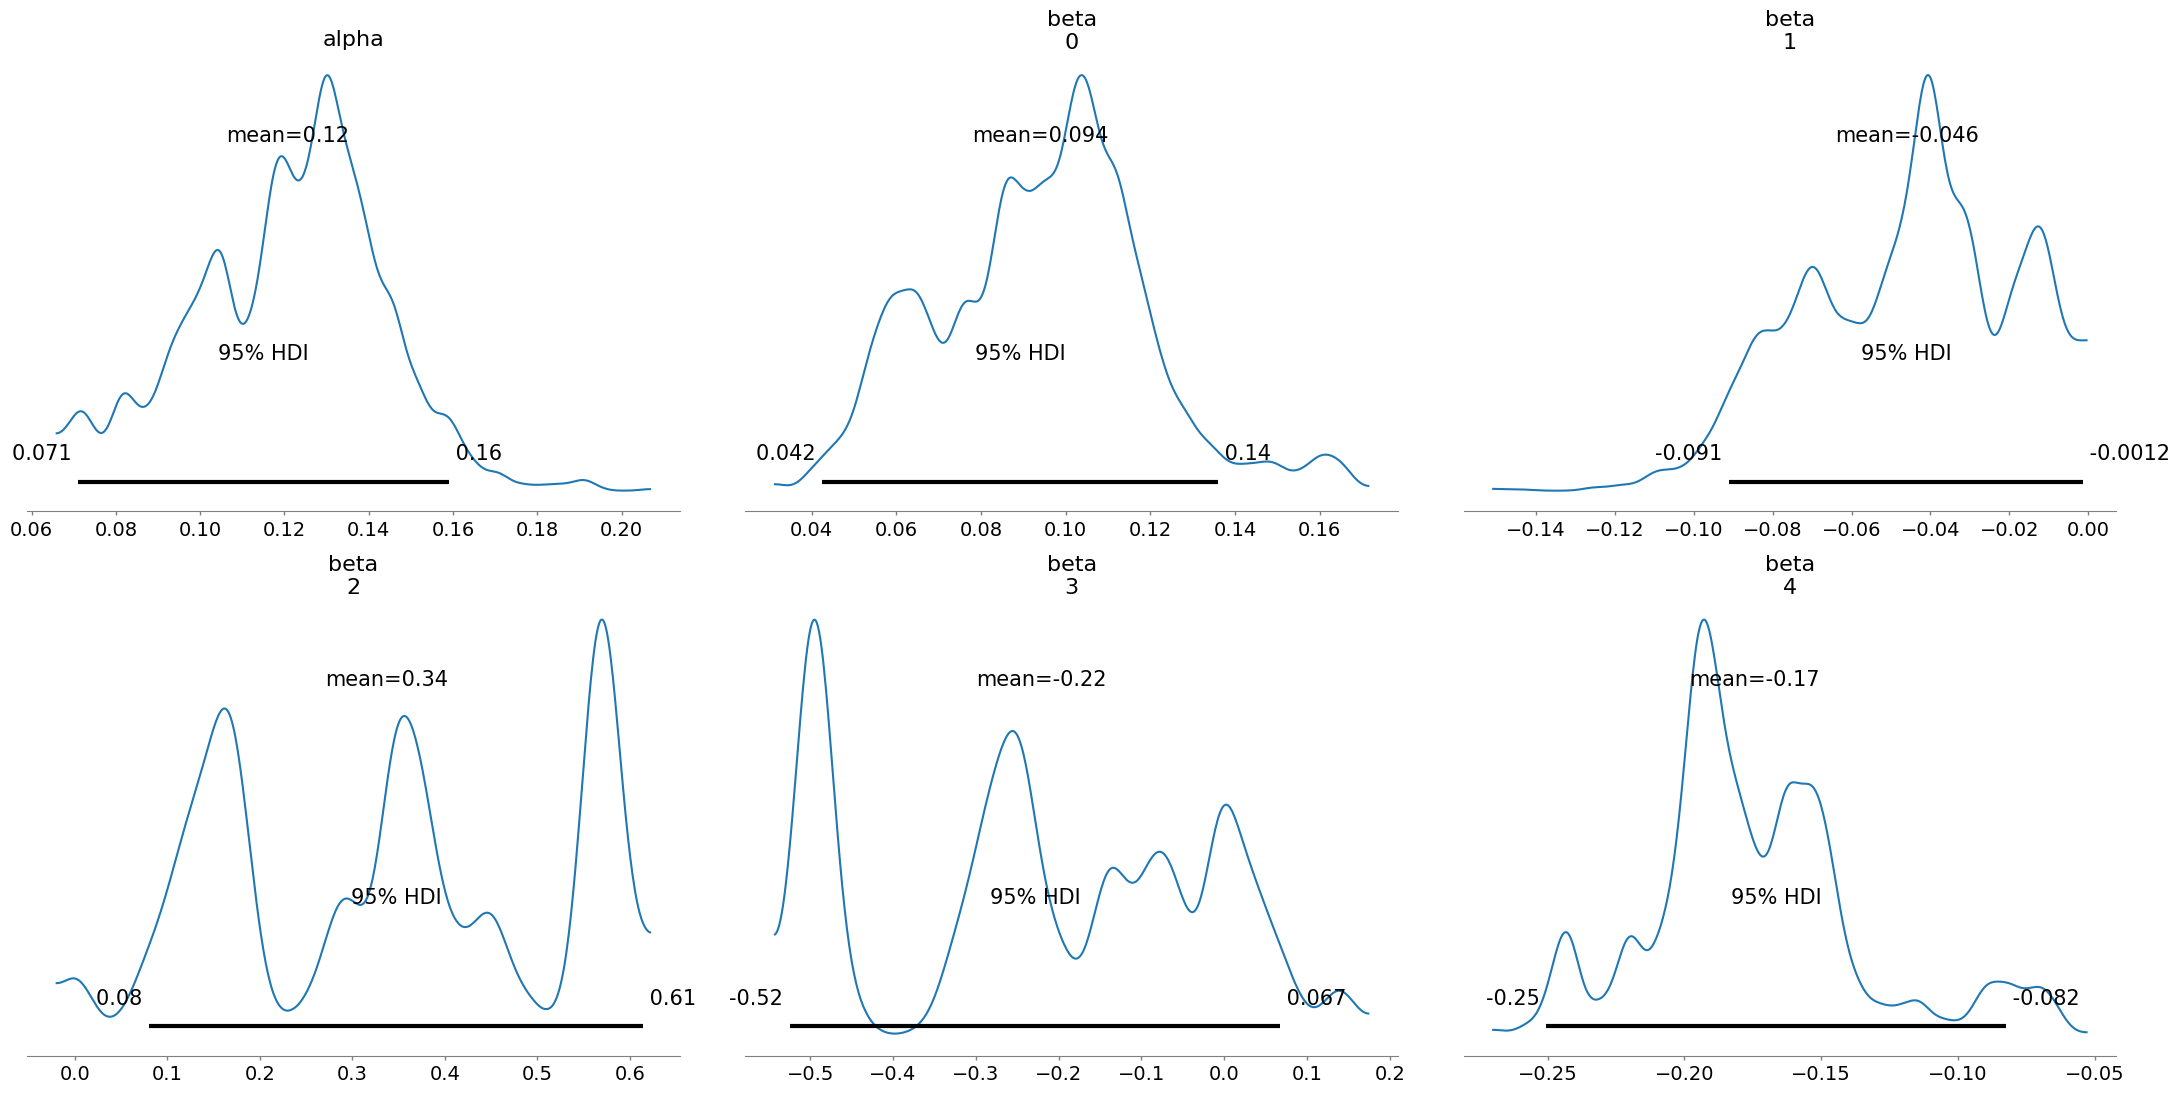

In [71]:
# === MODELOWANIE WŁAŚCIWE ===
model_fit = CmdStanModel(stan_file="./project/data_analytics/model1_fit.stan")
fit = model_fit.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    seed=42
)

idata = az.from_cmdstanpy(posterior=fit)

# === Statystyki próbkowania ===
summary = az.summary(idata, var_names=["alpha", "beta"])
print(summary[["r_hat", "ess_bulk", "ess_tail"]])
print("Divergences:", int(idata.sample_stats["diverging"].sum()))

# === TRACEPLOTS i POSTERIOR ===
az.plot_trace(idata, var_names=["alpha", "beta"], compact=True)
plt.tight_layout()
plt.show()

az.plot_posterior(
    idata,
    var_names=["alpha", "beta"],
    coords={"beta_dim_0": list(range(5))},  # możesz zmienić liczbę pokazywanych bet
    hdi_prob=0.95
)
plt.tight_layout()
plt.show()

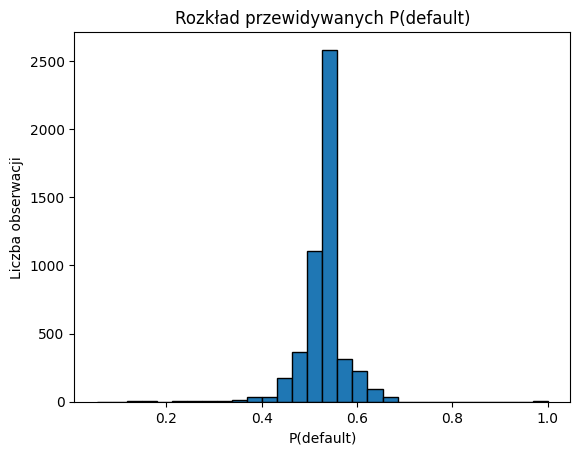

Dokładność klasyfikacji: 0.53


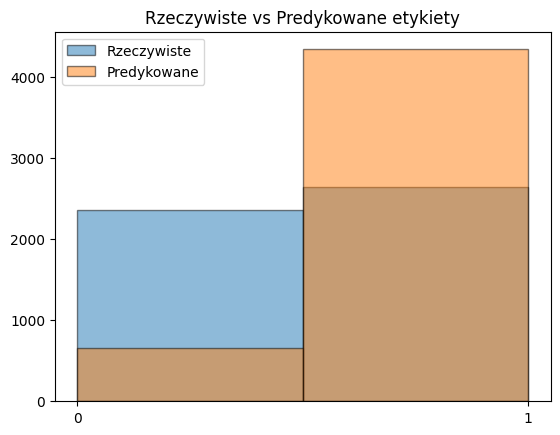

In [72]:
# === PREDYKCJA ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
alpha_mean = posterior_means["alpha"].values.item()
beta_mean = posterior_means["beta"].values

logits = alpha_mean + X @ beta_mean
probs = 1 / (1 + np.exp(-logits))

plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych P(default)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()

# === KLASYFIKACJA (porównanie z rzeczywistością) ===
y_pred = (probs > 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Dokładność klasyfikacji: {acc:.2f}")

plt.hist(y, bins=2, alpha=0.5, label="Rzeczywiste", edgecolor='k')
plt.hist(y_pred, bins=2, alpha=0.5, label="Predykowane", edgecolor='k')
plt.xticks([0, 1])
plt.legend()
plt.title("Rzeczywiste vs Predykowane etykiety")
plt.show()
